# Anime Recommendation System: Introduction

## Objective
The goal of this project is to build a **recommendation system** that can suggest anime to users based on their past ratings and anime characteristics.

## Dataset Overview
We are using the [Anime Dataset](#https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=rating.csv) containing:
- **Anime information**: anime_id,name,genre,type,episodes,rating,members.
- **User ratings**: user_id,anime_id,rating.

## Project Goals
1. Explore and preprocess the dataset to handle sparsity, missing values and noisy ratings.
2. Implement multiple recommendation techniques:
    - **Baseline recommendation**: Simple popularity-based recommendations.
    - **Collaborative Filtering (CF)**: Suggest anime based on user-user or item-item similarity.
    - **Content-Based Filtering (CBF)**: Recommend anime using genre, type, and other features.
    - **Hybrid approaches**: Combine CF and CBF for better predictions.
3. Evaluate model performance using metrics like **RMSE** and **MAE**.
4. Visualise recommendations and analyze patterns in user preferences and anime clusters.

## Why This Matters
Recommendation systems help users **discover content they are likely to enjoy** and are a critical part of many modern applications. By combining user behavior and content features, I aim to build a system that can provide **personalized anime recommendations** and gain insights into anime clustering and user preferences.

In [30]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
import time
from scipy.sparse import csr_matrix
import scipy.sparse as sp
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


# Data Preprocessing

Before building any recommendation system, we need to **clean, preprocess and structure the data**. This involves:

1. **Handling missing values**. 
2. **Filtering invalid ratings**.  
4. **Creating a user-item rating matrix**.

In [31]:
# Loading datasets

anime_df = pd.read_csv('data/anime.csv')
ratings_df = pd.read_csv('data/rating.csv')

print(f"Anime dataset: {anime_df.shape}")
print(f"Ratings dataset: {ratings_df.shape}")

# Displaying basic information

print(f"Unique anime: {anime_df['anime_id'].nunique()}")
print(f"Unique users: {ratings_df['user_id'].nunique()}")
print(f"Total ratings: {ratings_df['rating'].value_counts()}")

# Display data 

print(anime_df.head())
print(ratings_df.head())

Anime dataset: (12294, 7)
Ratings dataset: (7813737, 3)
Unique anime: 12294
Unique users: 73515
Total ratings: rating
 8     1646019
-1     1476496
 7     1375287
 9     1254096
 10     955715
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: count, dtype: int64
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17

In [32]:
# Cleaning anime data

anime_df['rating'] = pd.to_numeric(anime_df['rating'], errors='coerce')
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')
anime_df['members'] = pd.to_numeric(anime_df['members'], errors='coerce')

# removing all anime without ratings (-1) and adult content

anime_clean = anime_df.dropna(subset=['rating'].copy())
anime_clean = anime_clean[~anime_clean['genre'].str.contains('Hentai', case=False, na=False)].copy()
print(f"Anime entries after cleaning: {len(anime_clean)}")

# Cleaning rating data

ratings_clean = ratings_df[(ratings_df['rating'] != -1) & (ratings_df['rating'].notna())].copy()
print(f"Ratings after cleaning: {len(ratings_clean)}")

# Removing all users and items with few interactions (deals with the sparcity)

user_counts = ratings_clean['user_id'].value_counts()
item_counts = ratings_clean['anime_id'].value_counts()

# Keeping anime with at least 5 ratings

min_user_ratings = 5
min_item_ratings = 5

valid_users = user_counts[user_counts >= min_user_ratings].index
valid_items = item_counts[item_counts >= min_item_ratings].index

ratings_filtered = ratings_clean[
    (ratings_clean['user_id'].isin(valid_users)) & 
    (ratings_clean['anime_id'].isin(valid_items))
].copy()

print(ratings_filtered.head())

# Calculating sparcity

n_users = ratings_filtered['user_id'].nunique()
n_items = ratings_filtered['anime_id'].nunique()
n_ratings = len(ratings_filtered)
sparsity = (1 - n_ratings / (n_users * n_items)) * 100

print(f"Users: {n_users:,}")
print(f"Items: {n_items:,}")
print(f"Ratings: {n_ratings:,}")
print(f"Sparsity: {sparsity:.2f}%")
print(f"Avg ratings per user: {n_ratings/n_users:.1f}")
print(f"Avg ratings per item: {n_ratings/n_items:.1f}")



Anime entries after cleaning: 10931
Ratings after cleaning: 6337241
     user_id  anime_id  rating
156        3        20       8
157        3       154       6
158        3       170       9
159        3       199      10
160        3       225       9
Users: 60,970
Items: 8,030
Ratings: 6,314,650
Sparsity: 98.71%
Avg ratings per user: 103.6
Avg ratings per item: 786.4


## Popularity Baseline Recommender

The first step in building our recommendation system, we implement a **popularity-based baseline**. This baseline recommends the most popular items to all users, ignoring personal preferences. 

### How it Works:
1. **Fit Phase**:
- Compute average rating and count for each item.
- Filter items with too few ratings (to reduce noise).
- Rank items by average rating to determine popularity.
2. **Prediction**:
- If the item exists in the popular list, return its average rating.
- Otherwise, return the global average rating.
3. **Recommendation**:
- Return top-N popular items.
- Optionally, exclude items the user has already seen.

In [33]:
class PopularityBaseline:

    def __init__(self):

        self.popular_items = None
        self.global_mean = None

    def fit(self, ratings_df):
        # Learns the most popular anime from the data

        # Calculate the popularity score

        item_stats = ratings_df.groupby('anime_id').agg({'rating' : ['mean','count']}).round(3)
        item_stats.columns = ['avg_rating','rating_count']

        # Only get anime with more than 10 ratings

        item_stats = item_stats[item_stats['rating_count'] >= 10]

        # Sort the anime by their avg_rating
        self.popular_items = item_stats.sort_values('avg_rating', ascending = False)
        self.global_mean = ratings_df['rating'].mean()

        print(f"Baseline trained on {len(item_stats)} popular items")
        return self
    
    def set_item_mappings(self, item_to_idx):

        self.item_to_idx = item_to_idx
            
        if self.popular_items is None:
            print("Warning: Model not fitted yet!")
            return
                
        popular_item_ids = self.popular_items.index.tolist()
        
        # Convert popular item IDs to indices

        self.popular_item_indices = []
        for item_id in popular_item_ids:
            if item_id in item_to_idx:
                self.popular_item_indices.append(item_to_idx[item_id])
        
        print(f"Baseline: Mapped {len(self.popular_item_indices)} popular items to indices")
        return self

    def predict(self, user_id, item_id):
        # Predicts the rating for a user-item pair
        if self.popular_items is None:
            return self.global_mean
        
        if item_id in self.popular_items.index:
            return self.popular_items.loc[item_id, 'avg_rating']
        else:
            return self.global_mean
        
    def recommend(self, user_idx, n_recommendations=10, exclude_seen=True):

        if self.popular_item_indices is None:
            print("Warning: Item mappings not set. Call set_item_mappings() first.")
            return []
        
        # Return top N popular item indices
        return self.popular_item_indices[:n_recommendations]

    def recommend_by_id(self, user_id, n_recommendations=10, exclude_seen=None):

        if self.popular_items is None:
            return []
            
        recommendations = self.popular_items.head(n_recommendations).index.tolist()
        
        if exclude_seen:
            recommendations = [item for item in recommendations if item not in exclude_seen]
            # Fill up to n_recommendations if needed
            remaining = n_recommendations - len(recommendations)
            if remaining > 0:
                additional = self.popular_items.iloc[n_recommendations:n_recommendations+remaining*2]
                for item in additional.index:
                    if item not in exclude_seen:
                        recommendations.append(item)
                        if len(recommendations) >= n_recommendations:
                            break

        return self.popular_item_indices[:n_recommendations]

In [34]:
# Train baseline model
print("Training Popularity Baseline")
baseline_model = PopularityBaseline()
baseline_model.fit(ratings_filtered)

# Show the top recommendation

top_anime_ids = baseline_model.popular_items.head(10).index
for i, anime_id in enumerate(top_anime_ids, 1):
    anime_name = anime_clean[anime_clean['anime_id'] == anime_id]['name'].iloc[0]
    avg_rating = baseline_model.popular_items.loc[anime_id, 'avg_rating']
    rating_count = baseline_model.popular_items.loc[anime_id, 'rating_count']
    print(f'{1:2d}. {anime_name[:40]:40} | Rating: {avg_rating:.2f} |Count: {rating_count:,}')

Training Popularity Baseline
Baseline trained on 7364 popular items
 1. Gintama°                                 | Rating: 9.45 |Count: 1,182
 1. Kimi no Na wa.                           | Rating: 9.42 |Count: 1,948
 1. Ginga Eiyuu Densetsu                     | Rating: 9.39 |Count: 799
 1. Fullmetal Alchemist: Brotherhood         | Rating: 9.32 |Count: 21,220
 1. Gintama&#039;                            | Rating: 9.27 |Count: 3,098
 1. Steins;Gate                              | Rating: 9.26 |Count: 17,019
 1. Hunter x Hunter (2011)                   | Rating: 9.23 |Count: 7,418
 1. Gintama                                  | Rating: 9.23 |Count: 4,222
 1. Gintama&#039;: Enchousen                 | Rating: 9.20 |Count: 2,121
 1. Gintama Movie: Kanketsu-hen - Yorozuya y | Rating: 9.19 |Count: 2,139


## Content-Based Filtering for Anime Recommendations

This section implements a **content-based recommendation system** that leverages **anime features** to generate personalised recommendations.

### Key Steps:

1. **Feature Preparation**
   - Genre features transformed using **TF-IDF**.
   - Anime type features encoded as **one-hot vectors**.
   - Numeric features like `rating`, `episodes`, and `members` **normalised**.
   - Combined all features into a **single feature matrix**.

2. **Similarity Computation**
   - Compute **cosine similarity** between all anime.
   - Store similarity matrix.

3. **Personalized Recommendation**
   - For each anime a user has rated, retrieve similar anime.
   - Weight similarity scores by the user’s rating.
   - Aggregate scores and sort to recommend the top-N anime.

In [35]:
class ContentBasedFilter:

    def __init__(self):
        self.item_features = None
        self.item_similarity_matrix = None
        self.tfidf_vectorizer = None
        self.anime_to_idx = None
        self.idx_to_anime = None

    def prepare_features(self, anime_df):
        # preparing the feature matrix for anime


        anime_ids = anime_df['anime_id'].values
        self.anime_to_idx = {anime_id: idx for idx, anime_id in enumerate(anime_ids)}
        self.idx_to_anime = {idx : anime_id for anime_id, idx in self.anime_to_idx.items()}

        features_list = []

        # Genres features using TF-IDF

        genres = anime_df['genre'].fillna('Unknown')
        self.tfidf_vectorizer = TfidfVectorizer(max_features=50, stop_words=None)
        genre_features = self.tfidf_vectorizer.fit_transform(genres).toarray()
        features_list.append(genre_features)

        # Type features

        type_dummies = pd.get_dummies(anime_df['type']).values
        features_list.append(type_dummies)

        # Numerical features (normalised)

        numerical_features = anime_df[['rating', 'episodes', 'members']].copy()
        numerical_features['episodes'] = numerical_features['episodes'].fillna(1)

        # normalise numerical features 
        for col in numerical_features.columns:
            numerical_features[col] = (numerical_features[col] - numerical_features[col].mean()) / numerical_features[col].std()

        features_list.append(numerical_features.values)

        # Combine all features

        self.item_features = np.hstack(features_list)

        print(f"Content features prepared: {self.item_features.shape}")
        return self
    
    def fit(self, anime_df):
        # Train the content-based model

        self.prepare_features(anime_df)

        # Calculate the item similarity matrix

        print("Calculating item simularity matrix")
        self.item_similarity_matrix = cosine_similarity(self.item_features)

        print("Training complete")
        print(f"Feature dimensions: {self.item_features.shape[1]}")
        print(f"Items: {self.item_features.shape[0]}")

        return self
    

    def get_silmilar_items(self, anime_id, n_similar=50):
        # Get the most similar items to the anime given

        if anime_id not in self.anime_to_idx:
            return []
        
        item_idx = self.anime_to_idx[anime_id]
        similarities = self.item_similarity_matrix[item_idx]

        # Get indicies of the most similar items (except itself)

        similar_indices = np.argsort(similarities)[::-1][1:n_similar+1]
        similar_anime_ids = [self.idx_to_anime[idx] for idx in similar_indices]
        similarity_scores = similarities[similar_indices]

        return list(zip(similar_anime_ids, similarity_scores))
    
    def recommend(self, user_ratings, n_recommendations = 10):
        # Recommend item based on the user's rating history
        # user_ratings : dict {anime_id, rating}

        if not user_ratings:
            return []
        
        item_scores = defaultdict(float)
        item_weights = defaultdict(float)

        for rated_anime_id, rating in user_ratings.items():
            if rated_anime_id not in self.anime_to_idx:
                continue

                # Get similar items to the given anime

            similar_items = self.get_silmilar_items(rated_anime_id, n_similar=50)

            for similar_anime_id, similarity in similar_items:
                if similar_anime_id not in user_ratings: # Avoid recommending watched anime
                    # Weight similarity by user's rating (higher rated items get more weight)
                    weight = (rating - 5) * similarity 
                    item_scores[similar_anime_id] += item_weights
                    item_weights[similar_anime_id] += abs(similarity)

            # Calculate the final scores
            final_scores = {}
            for anime_id in item_scores:
                if item_weights[anime_id] > 0:
                       final_scores[anime_id] = item_scores[anime_id]/ item_weights[anime_id]

            # Sort the final scores
            recommendations = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
            return [anime_id for anime_id, score in recommendations[:n_recommendations]]


In [36]:
# Training content-based filter
print("Training content-based filter")
content_filter = ContentBasedFilter()
content_filter.fit(anime_clean)

# Example: find an anime similar to a popular one
sample_anime_id = anime_clean.iloc[449]['anime_id']
sample_anime_name = anime_clean.iloc[449]['name']

print(f"Finding similar anime to {sample_anime_name}")
similar_anime = content_filter.get_silmilar_items(sample_anime_id, n_similar=5)

for i, (anime_id, similarity) in enumerate(similar_anime, 1):
    anime_name = anime_clean[anime_clean['anime_id'] == anime_id]['name']
    if not anime_name.empty:
        print(f"{i}. {anime_name.iloc[0][:40]:40} | Similarity {similarity:.3f}")

Training content-based filter
Content features prepared: (10931, 56)
Calculating item simularity matrix
Training complete
Feature dimensions: 56
Items: 10931
Finding similar anime to Tokyo Ghoul
1. Elfen Lied                               | Similarity 0.999
2. Tokyo Ghoul √A                           | Similarity 0.997
3. Mirai Nikki (TV)                         | Similarity 0.996
4. Death Note                               | Similarity 0.995
5. Angel Beats!                             | Similarity 0.995


# User-Based Collaborative Filtering

Now that we have popularity and content-based approaches, we implement **Collaborative Filtering (CF)**, 
which leverages similarities between users to generate recommendations. 

### Key Steps:
1. **User-Item Matrix Creation**  
   - Construct a sparse matrix where each row corresponds to a user and each column corresponds to an anime.  
   - Matrix entries represent ratings (0 if unrated).  
   - Also generate index mappings for users and items.  

2. **User-Based CF Algorithm**  
   - Calculate similarity between users using **cosine similarity** on their overlapping ratings.  
   - Predict ratings for unseen anime based on ratings from similar users.  
   - Use weighted averages where more similar users have greater influence.  

3. **Model Training & Recommendations**  
   - Fit the CF model on the user-item matrix.  
   - For a given user, recommend anime they haven’t rated yet by predicting which ones they would likely rate highly.  
   - Demonstrate recommendations for a sample user.  


In [37]:
def create_user_item_matrix(ratings_df):
    # Creates a spase user_item rating matrix

    # Creat mappings for matrix indices

    user_ids = sorted(ratings_df['user_id'].unique())
    item_ids = sorted(ratings_df['anime_id'].unique())

    user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
    item_to_idx = {item_id: idx for idx, item_id in enumerate(item_ids)}

    # Create matrix

    n_users, n_items = len(user_ids), len(item_ids)
    matrix = np.zeros((n_users, n_items))

    for _, row in ratings_df.iterrows():
        user_idx = user_to_idx[row['user_id']]
        item_idx = item_to_idx[row['anime_id']]
        matrix[user_idx, item_idx] = row['rating']

    return matrix, user_to_idx, item_to_idx, user_ids, item_ids

In [38]:
# Creating sample matrix
print('Creating user-item matrix')

sample_size = 300000
ratings_sample = ratings_filtered.sample(n=min(sample_size, len(ratings_filtered)), random_state=42)
user_item_matrix, user_to_index, item_to_index, user_ids, item_ids = create_user_item_matrix(ratings_filtered)

print(f"User-item matrix shape: {user_item_matrix.shape}")
print(f"Non-zero entries: {np.count_nonzero(user_item_matrix):,}")
print(f"Sparsity: {(1 - np.count_nonzero(user_item_matrix) / user_item_matrix.size) * 100:.2f}%")

Creating user-item matrix
User-item matrix shape: (60970, 8030)
Non-zero entries: 6,314,643
Sparsity: 98.71%


In [39]:
class UserBasedCF:
    
    def __init__(self, k=50, similarity_threshold=0.1, method='knn_sparse', knn_algorithm='auto', n_jobs=-1):

        self.k = k
        self.similarity_threshold = similarity_threshold
        self.method = method  # 'knn_sparse', 'knn_sampling', 'locality_hashing'
        self.knn_algorithm = knn_algorithm
        self.n_jobs = n_jobs
        
        self.user_item_matrix = None
        self.user_means = None
        self.knn_model = None
        self.sparse_matrix = None
        
    def fit(self, user_item_matrix):
        # Fit the model with optimisations for larger datasets

        print(f"Training CF model on {user_item_matrix.shape} matrix")
        start_time = time.time()
        
        # Convert to sparse matrix for memory efficiency

        if not sp.issparse(user_item_matrix):
            print("Converting to sparse matrix...")
            self.sparse_matrix = csr_matrix(user_item_matrix)

            # Keep a small dense version for quick access during prediction
            
            self.user_item_matrix = user_item_matrix
        else:
            self.sparse_matrix = user_item_matrix
            self.user_item_matrix = user_item_matrix.toarray()
        
        print(f"Sparsity: {1 - self.sparse_matrix.nnz / (self.sparse_matrix.shape[0] * self.sparse_matrix.shape[1]):.4f}")
        
        # Calculate user means efficiently

        self._calculate_user_means()
        
        # Fit the appropriate model

        if self.method == 'knn_sparse':
            self._fit_sparse_knn()
        elif self.method == 'knn_sampling':
            self._fit_sampled_knn()
        elif self.method == 'locality_hashing':
            self._fit_lsh()
        
        fit_time = time.time() - start_time
        print(f"Model trained in {fit_time:.2f} seconds")
        
    def _calculate_user_means(self):
        # Calculate the user means efficiently for the sparce matrix

        if sp.issparse(self.sparse_matrix):

            # For sparse matrix, calculate means only on non-zero entries

            self.user_means = np.array([
                np.mean(self.sparse_matrix.getrow(i).data) if self.sparse_matrix.getrow(i).nnz > 0 else 0
                for i in range(self.sparse_matrix.shape[0])
            ])
        else:
            self.user_means = np.array([
                user_ratings[user_ratings > 0].mean() if np.any(user_ratings > 0) else 0 
                for user_ratings in self.user_item_matrix
            ])
    
    def _fit_sparse_knn(self):
        # Fit the KNN model using the sparse matrix operations
        print("Fitting sparse KNN model")
        
        # Use brute force with cosine similarity for sparse data

        self.knn_model = NearestNeighbors(
            n_neighbors=min(self.k + 1, self.sparse_matrix.shape[0]),
            algorithm='brute',
            metric='cosine',
            n_jobs=self.n_jobs
        )
        
        # Fit on sparse matrix directly

        self.knn_model.fit(self.sparse_matrix)
    
    def _fit_sampled_knn(self):
        # Fit the KNN using random sampling to reduce the computation time

        print("Fitting sampled KNN model")
        
        n_users = self.sparse_matrix.shape[0]

        # Sample a subset of users for building the index

        sample_size = min(10000, n_users // 2)  # Use at most 10k users for index
        
        sample_indices = np.random.choice(n_users, size=sample_size, replace=False)
        sample_matrix = self.sparse_matrix[sample_indices]
        
        self.knn_model = NearestNeighbors(
            n_neighbors=min(self.k + 1, sample_size),
            algorithm=self.knn_algorithm,
            metric='cosine',
            n_jobs=self.n_jobs
        )
        
        self.knn_model.fit(sample_matrix)
        self.sample_indices = sample_indices
    
    def _find_similar_users_fast(self, user_idx):
        # Find the users most similar to the fitted model

        if self.method == 'knn_sparse':
            user_vector = self.sparse_matrix.getrow(user_idx)
            distances, indices = self.knn_model.kneighbors(user_vector)
            
            # Convert distances to similarities and remove self

            similarities = 1 - distances[0][1:]
            neighbor_indices = indices[0][1:]
            
        elif self.method == 'knn_sampling':
            user_vector = self.sparse_matrix.getrow(user_idx)
            distances, indices = self.knn_model.kneighbors(user_vector)
            
            # Map back to original indices

            similarities = 1 - distances[0]
            neighbor_indices = self.sample_indices[indices[0]]
            
            # Remove self if present

            mask = neighbor_indices != user_idx
            similarities = similarities[mask]
            neighbor_indices = neighbor_indices[mask]
        
        return neighbor_indices, similarities
    
    def predict(self, user_idx, item_idx):
        # Predict using the optimised simialrity search
        # Find similar users efficiently

        similar_users, similarities = self._find_similar_users_fast(user_idx)
        
        # Filter users who have rated this item

        valid_similarities = []
        valid_ratings = []
        
        for i, other_user_idx in enumerate(similar_users[:self.k]):  # Limit to top-k
            if self.user_item_matrix[other_user_idx, item_idx] > 0:
                sim = similarities[i]
                if sim > self.similarity_threshold:
                    valid_similarities.append(sim)
                    valid_ratings.append(self.user_item_matrix[other_user_idx, item_idx])
        
        # If no similar users found, return user mean or global default

        if not valid_similarities:
            return self.user_means[user_idx] if self.user_means[user_idx] > 0 else 3.0
        
        # Weighted average prediction
        valid_similarities = np.array(valid_similarities)
        valid_ratings = np.array(valid_ratings)
        
        predicted_rating = np.sum(valid_similarities * valid_ratings) / np.sum(valid_similarities)
        return np.clip(predicted_rating, 1, 10)
    
    def predict_batch(self, user_item_pairs):
        # Predict ratings for multiple user-item pairs efficiently

        predictions = []
        
        # Group by user to reuse similarity computations

        user_groups = {}
        for i, (user_idx, item_idx) in enumerate(user_item_pairs):
            if user_idx not in user_groups:
                user_groups[user_idx] = []
            user_groups[user_idx].append((i, item_idx))
        
        results = [0] * len(user_item_pairs)
        
        for user_idx, items in user_groups.items():
            # Find similar users once per user

            similar_users, similarities = self._find_similar_users_fast(user_idx)
            
            for original_idx, item_idx in items:
                # Use precomputed similar users for this prediction

                valid_similarities = []
                valid_ratings = []
                
                for i, other_user_idx in enumerate(similar_users[:self.k]):
                    if self.user_item_matrix[other_user_idx, item_idx] > 0:
                        sim = similarities[i]
                        if sim > self.similarity_threshold:
                            valid_similarities.append(sim)
                            valid_ratings.append(self.user_item_matrix[other_user_idx, item_idx])
                
                if not valid_similarities:
                    pred = self.user_means[user_idx] if self.user_means[user_idx] > 0 else 3.0
                else:
                    valid_similarities = np.array(valid_similarities)
                    valid_ratings = np.array(valid_ratings)
                    pred = np.sum(valid_similarities * valid_ratings) / np.sum(valid_similarities)
                    pred = np.clip(pred, 1, 10)
                
                results[original_idx] = pred
        
        return np.array(results)
    
    def recommend(self, user_idx, n_recommendations=10, exclude_seen=True):
        # Generate recommendations

        user_ratings = self.user_item_matrix[user_idx]
        
        if exclude_seen:
            candidate_items = np.where(user_ratings == 0)[0]
        else:
            candidate_items = np.arange(len(user_ratings))
        
        if len(candidate_items) == 0:
            return []
        
        # Limit candidates if too many (for performance)

        if len(candidate_items) > 1000:
            # Sample candidates or use other heuristics

            candidate_items = np.random.choice(candidate_items, size=1000, replace=False)
        
        # Batch predict for efficiency

        user_item_pairs = [(user_idx, item_idx) for item_idx in candidate_items]
        predictions = self.predict_batch(user_item_pairs)
        
        # Sort and return top N
        
        item_pred_pairs = list(zip(candidate_items, predictions))
        item_pred_pairs.sort(key=lambda x: x[1], reverse=True)
        
        return [item_idx for item_idx, _ in item_pred_pairs[:n_recommendations]]

In [40]:
# Training user-based CF
print("Training user-based collaborative filtering")
user_cf = UserBasedCF(k=50, method='knn_sparse', n_jobs=-1)
user_cf.fit(user_item_matrix)

# Example recommendation

test_user_idx = 0
if test_user_idx < len(user_item_matrix):
    print(f"Sample recommendations for User : {user_ids[test_user_idx]}:")
    recommendations = user_cf.recommend(test_user_idx, n_recommendations=5)

    for i, item_idx in enumerate(recommendations,1):
        item_id = item_ids[item_idx]
        anime_name = anime_clean[anime_clean["anime_id"] == item_id]['name']
        if not anime_name.empty:
            predicted_rating = user_cf.predict(test_user_idx, item_idx)
            print(f"{i}. {anime_name.iloc[0][:40]:40} | Predicted Rating: {predicted_rating:.2f}")

Training user-based collaborative filtering
Training CF model on (60970, 8030) matrix
Converting to sparse matrix...
Sparsity: 0.9871
Fitting sparse KNN model
Model trained in 4.08 seconds
Sample recommendations for User : 3:
1. Dragon Ball: Super Saiya-jin Zetsumetsu  | Predicted Rating: 10.00
2. Tengen Toppa Gurren Lagann Movie: Lagann | Predicted Rating: 10.00
3. Bakemono no Ko                           | Predicted Rating: 10.00
4. Toki wo Kakeru Shoujo                    | Predicted Rating: 10.00
5. One Piece: Episode of Luffy - Hand Islan | Predicted Rating: 10.00


## Hybrid Recommendation System – Matrix Factorisation (SVD)

Matrix Factorisation is a latent-factor approach that reduces the high-dimensional user–item rating matrix into a smaller set of **hidden features** that capture patterns in user preferences and item attributes.

### Key Idea
Instead of relying only on observed similarities (like CF) or metadata (like content-based), this method learns a **compressed representation** of both users and items:
- **Users** are mapped into a latent feature space based on their rating behavior.
- **Items** are mapped into the same latent space based on who rated them and how.
- The interaction between a user’s vector and an item’s vector predicts ratings.

### Steps in Implementation
1. **Global Mean Centering**  
   - Calculate the average rating across the dataset.  
   - Subtract this mean from observed ratings to focus on relative preferences.

2. **Truncated SVD**  
   - Decompose the user–item matrix into:  
     - `user_factors` → low-dimensional user representations.  
     - `item_factors` → low-dimensional item representations.  

3. **Prediction**  
   - For user *u* and item *i*, the rating is estimated as:  
     \[
     \hat{r}_{ui} = \mu + U_u \cdot V_i
     \]  
     Where \(\mu\) is the global mean rating, and \(U_u, V_i\) are latent vectors.

4. **Recommendation**  
   - Predict scores for all unrated items.  
   - Rank them and recommend the top-N highest scoring items.



In [41]:
class MatrixFactorisationSVD:
    # Matrix Factorisation using Truncated SVD

    def __init__(self, n_components = 50):
        self.n_components = n_components
        self.svd = None
        self.user_factors = None
        self.item_factors = None
        self.global_mean = None

    def fit(self, user_item_matrix):
        # Training the SVD model 

        print(f"Training matrix factorisation (SVD) with {self.n_components} components")

        self.global_mean = user_item_matrix[user_item_matrix > 0].mean()

        # Center centered matrix (only for non-zero entries)

        centered_matrix = user_item_matrix.copy()
        mask = user_item_matrix > 0
        centered_matrix[mask] -= self.global_mean

        # Apply SVD

        self.svd = TruncatedSVD(n_components=self.n_components, random_state=42)
        self.user_factors = self.svd.fit_transform(centered_matrix)

        # Get item factors

        self.item_factors = self.svd.components_.T

        print(f"SVD model trained")
        print(f"Explained variance ratio: {self.svd.explained_variance_ratio_.sum():.3f}")
        
        return self
    
    def predict(self, user_idx, item_idx):
        # Predict the rating for user-item pairs

        prediction = self.global_mean + np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
        return np.clip(prediction, 1, 10)
    
    def recommend(self, user_idx, n_recommendations=10, exclude_seen=True):
        # Recommend items for a user
        # Calculate predictions for all items

        user_vector = self.user_factors[user_idx]
        predictions = self.global_mean + np.dot(self.item_factors, user_vector)

        # Gret indices of top predictions

        top_indices = np.argsort(predictions)[::-1]

        recommendations = []

        for item_idx in top_indices:
            if len(recommendations) >= n_recommendations:
                break

            # Exclude items the user has already seen
            if exclude_seen and user_item_matrix[user_idx, item_idx] > 0:
                continue

            recommendations.append(item_idx)

        return recommendations

In [42]:
# Training SVD model 

print("Training Matrix Factorisation Mode")
svd_model = MatrixFactorisationSVD(n_components=50)
svd_model.fit(user_item_matrix)

# Example recommendations

if test_user_idx < len(user_item_matrix):
    print(f"SVD Recommendation for User {user_ids[test_user_idx]}:")
    svd_recommendations = svd_model.recommend(test_user_idx, n_recommendations = 5)
    for i, item_idx in enumerate(svd_recommendations, 1):
        item_id = item_ids[item_idx]
        anime_name = anime_clean[anime_clean['anime_id'] == item_id]['name']
        if not anime_name.empty:
            predicted_rating = svd_model.predict(test_user_idx, item_idx)
            print(f"{i}. {anime_name.iloc[0][:40]:40} | Predicted Rating: {predicted_rating:.2f}")

Training Matrix Factorisation Mode
Training matrix factorisation (SVD) with 50 components
SVD model trained
Explained variance ratio: 0.236
SVD Recommendation for User 3:
1. Dragon Ball                              | Predicted Rating: 9.01
2. One Punch Man                            | Predicted Rating: 8.75
3. Hunter x Hunter (2011)                   | Predicted Rating: 8.70
4. Angel Beats!                             | Predicted Rating: 8.58
5. Howl no Ugoku Shiro                      | Predicted Rating: 8.52


## Evaluation

To assess the performance of our recommendation models, we split the dataset into **train** and **test sets**.  
We use a **temporal split**, ensuring that for each user, their most recent ratings form the test set (20% of their ratings).  

We evaluate the models using two types of metrics:

- **Rating Prediction Metrics**
  - **RMSE (Root Mean Squared Error):** Measures the average difference between predicted and actual ratings. Lower is better.
  - **MAE (Mean Absolute Error):** Measures the absolute average difference. Lower is better.

- **Recommendation Quality Metrics**
  - **Precision@K:** Proportion of recommended items that are relevant.
  - **Recall@K:** Proportion of relevant items that were recommended.


In [43]:
def train_test_split_temporal(ratings_df, test_ratio = 0.4):
    # Split the data by time (the last 20% of each users ratings as test)

    train_data = []
    test_data = []

    for user_id in ratings_df['user_id'].unique():
        user_ratings = ratings_df[ratings_df['user_id'] == user_id]
        user_ratings = user_ratings.sample(frac=1, random_state=42)
        n_test = int(len(user_ratings) * test_ratio)
        if len(user_ratings) >= 10:  # only enforce min for users with enough ratings
            n_test = max(30, n_test)
        
        test_data.append(user_ratings.iloc[: n_test])
        train_data.append(user_ratings.iloc[n_test:])

    train_df = pd.concat(train_data, ignore_index=True)
    test_df = pd.concat(test_data, ignore_index=True)
    
    return train_df, test_df

In [44]:
def train_test_split_global(ratings_df, test_ratio=0.4, random_state=42):
    """
    Split the ratings globally into train and test sets.
    Ensures roughly `test_ratio` fraction of all ratings in the test set.
    """
    ratings_shuffled = ratings_df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    n_test = int(len(ratings_shuffled) * test_ratio)
    
    test_df = ratings_shuffled.iloc[:n_test].copy()
    train_df = ratings_shuffled.iloc[n_test:].copy()
    
    return train_df, test_df

In [45]:
def evaluate_predictions(y_true, y_pred):
    """Calculate RMSE and MAE"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

In [46]:
def evaluate_recommendations(model, test_data, user_to_index, item_to_index, index_to_item=None, k=100):
    # Create reverse mapping if not provided

    if index_to_item is None:
        index_to_item = {idx: item_id for item_id, idx in item_to_index.items()}
    
    print(f"\nDEBUGGING {model.__class__.__name__} Evaluation:")
    print(f"- Total items in test_data: {test_data['anime_id'].nunique()}")
    print(f"- User mapping size: {len(user_to_index)}")
    print(f"- Item mapping size: {len(item_to_index)}")
    print(f"- Reverse item mapping size: {len(index_to_item)}")

    precisions = []
    recalls = []
    successful_evaluations = 0
    failed_evaluations = 0
    debug_count = 0

    for user_id in test_data['user_id'].unique():
        if user_id not in user_to_index:
            continue

        user_idx = user_to_index[user_id]
        user_test_items = set(test_data[test_data['user_id'] == user_id]['anime_id'].values)

        print(f"\nDEBUG USER {debug_count + 1} (ID: {user_id}, Index: {user_idx}):")
        print(f"- Test items for this user: {list(user_test_items)[:10]}...")  # Show first 10
        print(f"- Number of test items: {len(user_test_items)}")
        
        try:
            # Get recommendations from model

            recommendation_indices = model.recommend(user_idx, n_recommendations=k)
            print(f'Size of recommended: {len(recommendation_indices)}')
            print(f"- Raw recommendation indices: {recommendation_indices}")

            if recommendation_indices:
                # Convert indices to item IDs

                recommended_items = set()
                for idx in recommendation_indices:
                    if idx in index_to_item:
                        recommended_items.append(index_to_item[idx])
                
                # Calculate precision and recall
                recommended_items_set = set(recommended_items)
                print(f"- Recommended item IDs: {recommended_items_set}")

                overlap = user_test_items.intersection(recommended_items_set)
                print(f"- Overlap between test and recommended: {list(overlap)}")
                print(f"- Number of overlapping items: {len(overlap)}")
                relevant_items = user_test_items.intersection(recommended_items_set)
                print(f'- Size of relevent items: {len(relevant_items)}')
                precision = len(relevant_items) / len(recommended_items_set) if recommended_items_set else 0
                recall = len(relevant_items) / len(user_test_items) if user_test_items else 0
                
                if recommended_items:  # Only calculate if we have valid recommendations
                    relevant_items = user_test_items.intersection(recommended_items)
                    
                    precision = len(relevant_items) / len(recommended_items)
                    recall = len(relevant_items) / len(user_test_items) if user_test_items else 0
                    
                    precisions.append(precision)
                    recalls.append(recall)
                    successful_evaluations += 1
                else:
                    # No valid recommendations after conversion
                    
                    precisions.append(0)
                    recalls.append(0)
                    successful_evaluations += 1
        except Exception as e:
            failed_evaluations += 1
            print(f"Failed to evaluate user {user_id}: {str(e)}")
            continue

    # Calculate averages
    
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
    
    print(f"Evaluation completed:")
    print(f"- Successful evaluations: {successful_evaluations}")
    print(f"- Failed evaluations: {failed_evaluations}")
    print(f"- Average Precision@{k}: {avg_precision:.4f}")
    print(f"- Average Recall@{k}: {avg_recall:.4f}")
    
    return avg_precision, avg_recall

In [47]:
def evaluate_recommendations_new(model, test_data, user_to_idx, item_to_idx, k=10):
    """Evaluate recommendation quality"""
    # Create reverse mapping
    idx_to_item = {idx: item_id for item_id, idx in item_to_idx.items()}
    
    precisions = []
    recalls = []
    successful_evaluations = 0
    failed_evaluations = 0
    
    print(f"Evaluating {model.__class__.__name__} with k={k}")
    print(f"- Users in test data: {test_data['user_id'].nunique()}")
    print(f"- Users in mapping: {len(user_to_idx)}")
    
    for user_id in test_data['user_id'].unique():
        if user_id not in user_to_idx:
            failed_evaluations += 1
            continue
            
        user_idx = user_to_idx[user_id]
        user_test_items = set(test_data[test_data['user_id'] == user_id]['anime_id'].values)
        
        try:
            # Get recommendations from model
            recommendation_indices = model.recommend(user_idx, n_recommendations=k, exclude_seen=True)
            
            if recommendation_indices:
                # Convert indices back to item IDs
                recommended_items = set()
                for idx in recommendation_indices:
                    if idx in idx_to_item:
                        recommended_items.add(idx_to_item[idx])
                
                if recommended_items:  # Only calculate if we have valid recommendations
                    relevant_items = user_test_items.intersection(recommended_items)
                    
                    precision = len(relevant_items) / len(recommended_items)
                    recall = len(relevant_items) / len(user_test_items) if user_test_items else 0
                    
                    precisions.append(precision)
                    recalls.append(recall)
                    successful_evaluations += 1
                else:
                    # No valid recommendations
                    precisions.append(0)
                    recalls.append(0)
                    successful_evaluations += 1
            else:
                # No recommendations generated
                precisions.append(0)
                recalls.append(0)
                successful_evaluations += 1
                
        except Exception as e:
            failed_evaluations += 1
            continue
    
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
    
    print(f"- Successful: {successful_evaluations}, Failed: {failed_evaluations}")
    print(f"- Precision@{k}: {avg_precision:.4f}")
    print(f"- Recall@{k}: {avg_recall:.4f}")
    
    return avg_precision, avg_recall

In [48]:
# Create train / test split

print("Creating train/test split")
train_ratings, test_ratings = train_test_split_global(ratings_sample, test_ratio=0.2)

print(f"Train set: {len(train_ratings):,} ratings")
print(f"Test set: {len(test_ratings):,} ratings")

train_matrix, train_user_to_idx, train_item_to_idx, train_user_ids, train_item_ids = create_user_item_matrix(train_ratings)

# Retrain models on training data

print("\nRetraining models on training data...")

# Retrain baseline

baseline_eval = PopularityBaseline()
baseline_eval.fit(train_ratings)
baseline_eval.set_item_mappings(train_item_to_idx)

# Retrain collaborative filtering

train_matrix, train_user_to_idx, train_item_to_idx, train_user_ids, train_item_ids = create_user_item_matrix(train_ratings)
user_cf_eval = UserBasedCF(k=50, method='knn_sparse', n_jobs=-1)
user_cf_eval.fit(train_matrix)

# Retrain SVD

svd_eval = MatrixFactorisationSVD(n_components=30)
svd_eval.fit(train_matrix)

# Evaluate rating prediction accuracy

print("Evaluation rating prediction accuracy")

# Collect predictions for test set

baseline_predictions = []
user_cf_predictions = []
svd_predictions = []
true_ratings = []

# Sample some predictions for evaluation

test_sample = test_ratings.sample(min(1000, len(test_ratings)), random_state=42)

for _, row in test_sample.iterrows():
    user_id, item_id, true_rating = row['user_id'], row['anime_id'], row['rating']

    # Skip if the user or the item is not in the training data

    if user_id not in train_user_to_idx or item_id not in train_item_to_idx:
        continue

    user_idx = train_user_to_idx[user_id]
    item_idx = train_item_to_idx[item_id]
    
    # Get predictions

    baseline_pred = baseline_eval.predict(user_id, item_id)
    user_cf_pred = user_cf_eval.predict(user_idx, item_idx)
    svd_pred = svd_eval.predict(user_idx, item_idx)
    
    baseline_predictions.append(baseline_pred)
    user_cf_predictions.append(user_cf_pred)
    svd_predictions.append(svd_pred)
    true_ratings.append(true_rating)

Creating train/test split
Train set: 240,000 ratings
Test set: 60,000 ratings

Retraining models on training data...
Baseline trained on 3008 popular items
Baseline: Mapped 3008 popular items to indices
Training CF model on (46653, 6518) matrix
Converting to sparse matrix...
Sparsity: 0.9992
Fitting sparse KNN model
Model trained in 3.10 seconds
Training matrix factorisation (SVD) with 30 components
SVD model trained
Explained variance ratio: 0.099
Evaluation rating prediction accuracy


In [49]:
test_ratings.groupby('user_id')['anime_id'].count().describe()


count    27911.000000
mean         2.149690
std          1.884906
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         35.000000
Name: anime_id, dtype: float64

In [50]:
if true_ratings:
    baseline_rmse, baseline_mae = evaluate_predictions(true_ratings, baseline_predictions)
    user_cf_rmse, user_cf_mae = evaluate_predictions(true_ratings, user_cf_predictions)
    svd_rmse, svd_mae = evaluate_predictions(true_ratings, svd_predictions)
    
    print(f"\nPREDICTION ACCURACY RESULTS:")
    print(f"{'Model':<20} {'RMSE':<8} {'MAE':<8}")
    print("-" * 50)
    print(f"{'Popularity Baseline':<20} {baseline_rmse:<8.3f} {baseline_mae:<8.3f}")
    print(f"{'User-based CF':<20} {user_cf_rmse:<8.3f} {user_cf_mae:<8.3f}")
    print(f"{'Matrix Factorization':<20} {svd_rmse:<8.3f} {svd_mae:<8.3f}")


PREDICTION ACCURACY RESULTS:
Model                RMSE     MAE     
--------------------------------------------------
Popularity Baseline  1.452    1.131   
User-based CF        1.532    1.137   
Matrix Factorization 1.550    1.219   


In [51]:
print("Evaluating baseline model")
baseline_precision, baseline_recall = evaluate_recommendations_new(baseline_eval, test_ratings, train_user_to_idx, train_item_to_idx)

print(f"\nRECOMMENDATION QUALITY RESULTS:")
print(f"{'Model':<20} {'Precision@10':<12} {'Recall@10':<12}")
print("-" * 50)
print(f"{'Popularity Baseline':<20} {baseline_precision:<12.3f} {baseline_recall:<12.3f}")

Evaluating baseline model
Evaluating PopularityBaseline with k=10
- Users in test data: 27911
- Users in mapping: 46653
- Successful: 25445, Failed: 2466
- Precision@10: 0.0026
- Recall@10: 0.0137

RECOMMENDATION QUALITY RESULTS:
Model                Precision@10 Recall@10   
--------------------------------------------------
Popularity Baseline  0.003        0.014       


In [52]:
print("Evaluating user CF model")
user_cf_precision, user_cf_recall = evaluate_recommendations_new(user_cf_eval, test_ratings, train_user_to_idx, train_item_to_idx)

print(f"\nRECOMMENDATION QUALITY RESULTS:")
print(f"{'Model':<20} {'Precision@10':<12} {'Recall@10':<12}")
print("-" * 50)
print(f"{'User-based CF':<20} {user_cf_precision:<12.3f} {user_cf_recall:<12.3f}")

Evaluating user CF model
Evaluating UserBasedCF with k=10
- Users in test data: 27911
- Users in mapping: 46653
- Successful: 25445, Failed: 2466
- Precision@10: 0.0007
- Recall@10: 0.0035

RECOMMENDATION QUALITY RESULTS:
Model                Precision@10 Recall@10   
--------------------------------------------------
User-based CF        0.001        0.004       


In [53]:
print("Evaluating Hybrid model")
svd_precision, svd_recall = evaluate_recommendations_new(svd_eval, test_ratings, train_user_to_idx, train_item_to_idx)

print(f"\nRECOMMENDATION QUALITY RESULTS:")
print(f"{'Model':<20} {'Precision@10':<12} {'Recall@10':<12}")
print("-" * 50)
print(f"{'Matrix Factorization':<20} {svd_precision:<12.3f} {svd_recall:<12.3f}")

Evaluating Hybrid model
Evaluating MatrixFactorisationSVD with k=10
- Users in test data: 27911
- Users in mapping: 46653
- Successful: 25445, Failed: 2466
- Precision@10: 0.0048
- Recall@10: 0.0261

RECOMMENDATION QUALITY RESULTS:
Model                Precision@10 Recall@10   
--------------------------------------------------
Matrix Factorization 0.005        0.026       


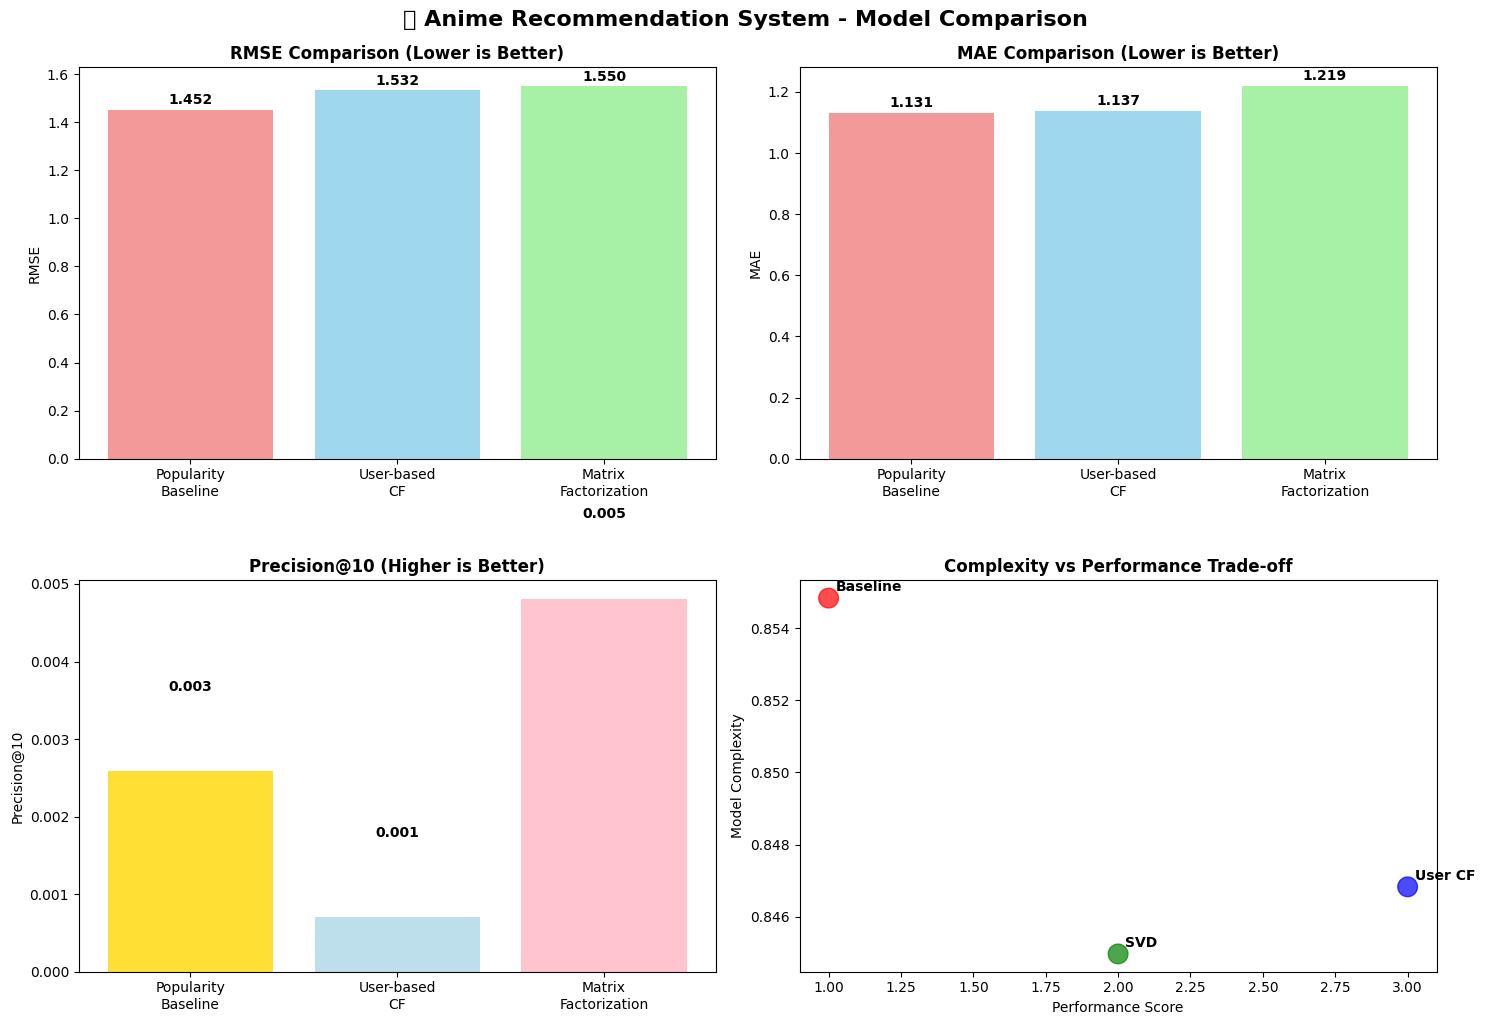

In [ ]:
# Create visualisations of the results

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

models = ['Popularity\nBaseline', 'User-based\nCF', 'Matrix\nFactorization']
rmse_scores = [baseline_rmse, user_cf_rmse, svd_rmse] if true_ratings else [0,0,0]
mae_scores = [baseline_mae, user_cf_mae, svd_mae] if true_ratings else [0,0,0]

# RMSE Comparison

bars1 = ax1.bar(models, rmse_scores, color=['lightcoral', 'skyblue', 'lightgreen'], alpha=0.8)
ax1.set_title('RMSE Comparison (Lower is Better)', fontweight='bold')
ax1.set_ylabel('RMSE')
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
# MAE Comparison

bars2 = ax2.bar(models, mae_scores, color=['lightcoral', 'skyblue', 'lightgreen'], alpha=0.8)
ax2.set_title('MAE Comparison (Lower is Better)', fontweight='bold')
ax2.set_ylabel('MAE')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    

# Precision Comparison

precision_scores = [baseline_precision, user_cf_precision, svd_precision]
bars3 = ax3.bar(models, precision_scores, color=['gold', 'lightblue', 'lightpink'], alpha=0.8)
ax3.set_title('Precision@10 (Higher is Better)', fontweight='bold')
ax3.set_ylabel('Precision@10')
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
# Model Complexity vs Performance

complexity_scores = [1,3,2] # 3 Being the most complex
performance_scores = [1-baseline_rmse/10, 1-user_cf_rmse/10, 1-svd_rmse/10] if true_ratings else [0.5, 0.6, 0.7]

scatter = ax4.scatter(complexity_scores, performance_scores, c = ['red','blue','green'], s = 200, alpha = 0.7)
ax4.set_ylabel("Model Complexity")
ax4.set_xlabel("Performance Score")
ax4.set_title('Complexity vs Performance Trade-off', fontweight='bold')

for i, model in enumerate(['Baseline', 'User CF', 'SVD']):
    ax4.annotate(model, (complexity_scores[i], performance_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

plt.tight_layout()
plt.suptitle('Anime Recommendation System - Model Comparison', 
             fontsize=16, fontweight='bold', y=1.02)

plt.savefig("Model_Comparison")
plt.show()

## Production-Ready Hybrid Recommendation System

To create a robust and user-friendly recommendation pipeline, I implemented a **hybrid recommendation system** that combines multiple models into a single framework. This design ensures the strengths of each approach compensate for the weaknesses of others, producing more reliable recommendations.

### System Design

The system integrates three core models:

1. **Popularity Baseline**  
   - Recommends anime based on global popularity.  
   - Provides a strong fallback when limited user history exists.  

2. **Content-Based Filtering**  
   - Uses anime metadata (e.g., genres, type, episodes) to recommend shows similar to the user’s preferences.  
   - Captures thematic or stylistic similarities.  

3. **Collaborative Filtering (SVD)**  
   - Learns latent features from the user–anime rating matrix.  
   - Predicts hidden preferences based on patterns across users.  

### Hybrid Scoring

Each model contributes to the final recommendation list with different weights:

- **Popularity Baseline:** 20%  
- **Content-Based Filtering:** 30%  
- **Collaborative Filtering (SVD):** 50%  

Recommendations are aggregated, scored, and sorted. Already-rated anime are filtered out before presenting the final results.

### Features

- **User Profile Construction:** Captures each user’s rated anime to avoid duplicates in recommendations.  
- **Hybrid Recommendation Generation:** Merges results from all models into one ranked list.  
- **Recommendation Explanation:** Provides transparency by showing whether a suggestion was driven by popularity, genre similarity, or collaborative filtering.  
- **Anime Metadata Retrieval:** Displays rich contextual details such as genre, type, average rating, and member counts.  

### Example Output

